# Test the sample and distributional accuracy of the GNN-based probabilistic models

In [1]:
import numpy as np
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import dgn4cfd as dgn 

In [2]:
device = torch.device('cuda:0')

Settings:

In [3]:
DATASET = dgn.datasets.DatasetUrl.pOnEllipseInDist
"""
Available test datasets:
    - DatasetUrl.pOnEllipseInDist
    - DatasetUrl.pOnEllipseLowRe
    - DatasetUrl.pOnEllipseHighRe
    - DatasetUrl.pOnEllipseThin
    - DatasetUrl.pOnEllipseThick
"""
TIME_DATASET = dgn.datasets.DatasetUrl.TimeEllipseInDist # This dataset contains the length of each simulation in DATASET. This lenght is a multiple of the vortex-shedding period.
NUM_DENOISING_STEPS = 50
SIM_IDX = 25

Load the models:
- Diffusion Graph Net (DGN)
- Latent Diffusion Graph Net (LDGN)
- Vanilla Graph Net
- Bayesian Graph Net
- Gaussian Mixure Graph Net
- Variational Graph Autoencoder (VGAE)
- Flow-Matching Graph Net (FMGN)
- Latent Flow-Matching Graph Net (LFMGN)

In [4]:
# Diffusion Graph Net
DGN = dgn.nn.DiffusionGraphNet(
    checkpoint = "./checkpoints/dgn-nt10.chk",
    device     = device,
)

# Latent Diffusion Graph Net
LDGN = dgn.nn.LatentDiffusionGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt10.chk",
    checkpoint             = "./checkpoints/ldgn-nt10.chk",
    device                 = device,
)

# Vanilla Graph Net
VanillaGN = dgn.nn.VanillaGnn(
    checkpoint = "./checkpoints/vanilla-nt10.chk",
    device     = device,
) 

# Bayesian Graph Net
BayesianGN = dgn.nn.BayesianGnn(
    checkpoint = "./checkpoints/bayesian-nt10.chk",
    device     = device,
)

# Gassian Mixure Graph Net
GaussianMixGN = dgn.nn.GaussianMixtureGnn(
    checkpoint = "./checkpoints/gaussian-nt10.chk",
    device     = device,
)

# Variational Graph Autoencoder
VGAE = dgn.nn.VGAE(
    checkpoint = "./checkpoints/vgae-nt10.chk",
    device     = device,
)

# Flow-Matching Graph Net
FMGN = dgn.nn.FlowMatchingGraphNet(
    checkpoint = "./checkpoints/fmgn-nt10.chk",
    device     = device,
)

# Latent Flow-Matching Graph Net
LFMGN = dgn.nn.LatentFlowMatchingGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt10.chk",
    checkpoint             = "./checkpoints/lfmgn-nt10.chk",
    device                 = device,
)

Define some plotting functions

In [5]:
def plot(pos, target, pred, r2):
    pos = pos.cpu()
    target = target.cpu()
    pred = pred.cpu()
    # Plots
    top = pos[:, 1] >= 0.
    bottom = torch.logical_not(top)
    plt.plot(pos[top   , 0].cpu(), target[top   ].cpu(), 'k^', label='g.t.  top wall')
    plt.plot(pos[bottom, 0].cpu(), target[bottom].cpu(), 'kv', label='g.t.  bottom wall')
    plt.plot(pos[top,    0].cpu(), pred  [top   ].cpu(), 'b^', label='pred. top wall',    alpha=0.4)
    plt.plot(pos[bottom, 0].cpu(), pred  [bottom].cpu(), 'bv', label='pred. bottom wall', alpha=0.4)
    plt.title(r'Pressure on the ellipse wall ($R^2$ = ' + f"{r2:.4f}" + r')', fontsize=16)
    plt.ylabel(r'$p$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=16)
    plt.show()


from scipy.stats import gaussian_kde

def pdf(pos, pred, title, vmin=None, vmax=None, w2_distance_1d=None, w2_distance_nd=None):
    pos = pos.cpu()
    ang = torch.atan2(pos[:,1], pos[:,0])
    idx = torch.argsort(ang)
    idx = idx[ang[idx] > 0]
    y = pred[idx].cpu().numpy()
    if vmin is None:
        vmin = y.min() - 0.1
    if vmax is None:
        vmax = y.max() + 0.1
    x = np.linspace(vmin, vmax, 1000)
    f = np.stack([gaussian_kde(y[i])(x) for i in range(y.shape[0])])
    f = f / f.max(axis=1)[:,None]

    plt.figure(figsize=(4, 5))
    plt.imshow(np.flip(f.T), aspect='auto', cmap='binary')
    plt.yticks(np.linspace(100, 900, 5), np.flip(np.round(x[np.linspace(100, 900, 5).astype(int)], 2)))
    plt.xticks([])
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=28)
    # Add a label with the Wasserstein-2 distance. It must be black with a white background and located on the top right corner and black border
    if w2_distance_1d is not None and w2_distance_nd is not None:
        plt.text(0.2, 0.76,  r'$W_2^\mathregular{node}$' + f'  = {w2_distance_1d:.4f} \n' + r'$W_2^\mathregular{graph}$' + f' = {w2_distance_nd:.4f}', fontsize=20, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), transform=plt.gca().transAxes)
    plt.show()

Load a dataset

In [6]:
# Training dataset
transform = transforms.Compose([
    dgn.transforms.MeshEllipse(),                               # Create a mesh on the ellipse
    dgn.transforms.ScaleEdgeAttr(0.02),                         # Scale the relative position stored as `edge_attr`
    dgn.transforms.EdgeCondFreeStreamProjection(),              # Add the projection of the free stream velocity along the edges as `edge_cond`
    dgn.transforms.ScaleAttr('target', vmin=-1.05, vmax=0.84),  # Scale the target field (pressure)
    dgn.transforms.ScaleAttr('glob',   vmin=500,   vmax=1000),  # Scale the global feature (Re)
    dgn.transforms.ScaleAttr('loc',    vmin=2,     vmax=3.5),   # Scale the local feature (distances to the walls)
    dgn.transforms.MeshCoarsening(                              # Create 3 lower-resolution graphs and normalise the relative position betwen the inter-graph nodes.
        num_scales      =  4,
        rel_pos_scaling = [0.02, 0.06, 0.15, 0.3],
        scalar_rel_pos  = True, 
    ),
])
dataset = dgn.datasets.pOnEllipse(
    path          = dgn.datasets.DatasetDownloader(DATASET).file_path,
    T             = 101,
    transform     = transform,
)
print('Number of samples:', len(dataset))

# Load the length of each simulation to compute statistics
T = dgn.datasets.DatasetDownloader(TIME_DATASET).numpy()

Dataset already exists.
Number of samples: 50
Dataset already exists.


## Sample Inference

We sample from the distribution learned by each model, given the conditioning node and edge features. To compute the sample accuracy (coefficient of determination in this case), we find in the dataset the ground-truth sample closest to the predicted sample.

DGN R2 = 0.9974 at t=21


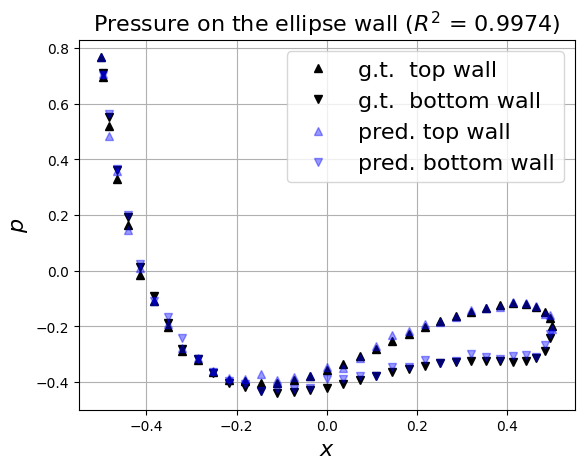

LDGN R2 = 0.9987 at t=76


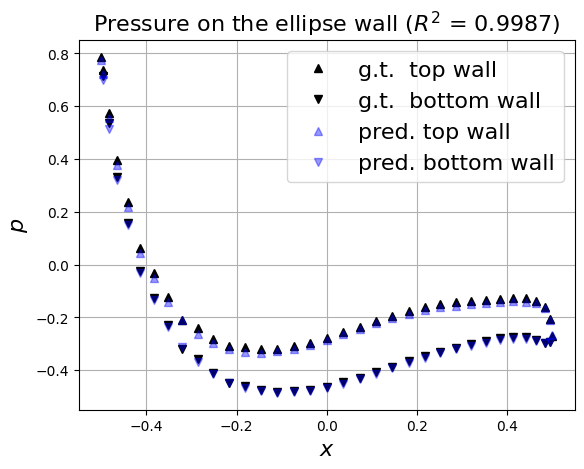

Vanilla Graph Net R2 = 0.9912 at t=6


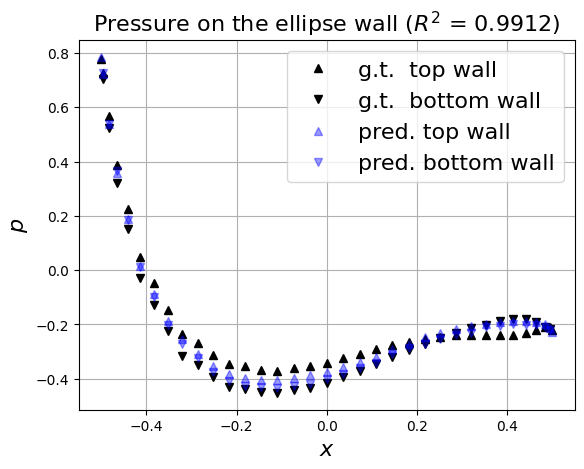

Bayesian Graph Net R2 = 0.9612 at t=18


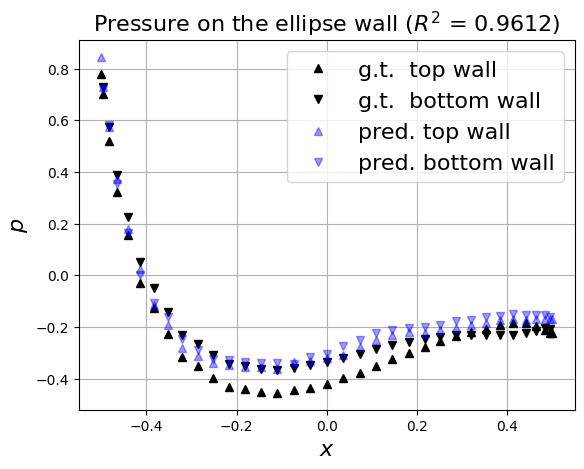

Gaussian Mixture Graph Net R2 = 0.9764 at t=53


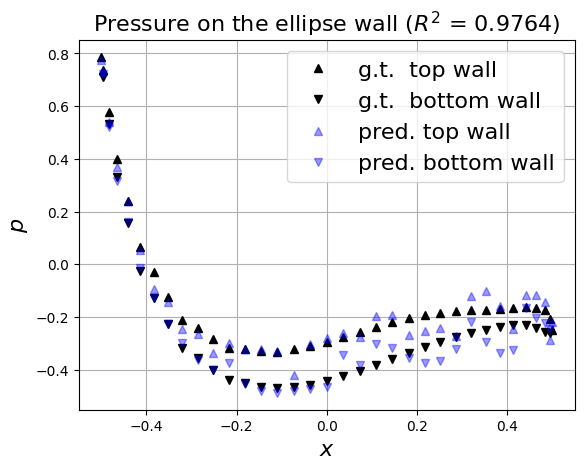

VGAE R2 = 0.9957 at t=79


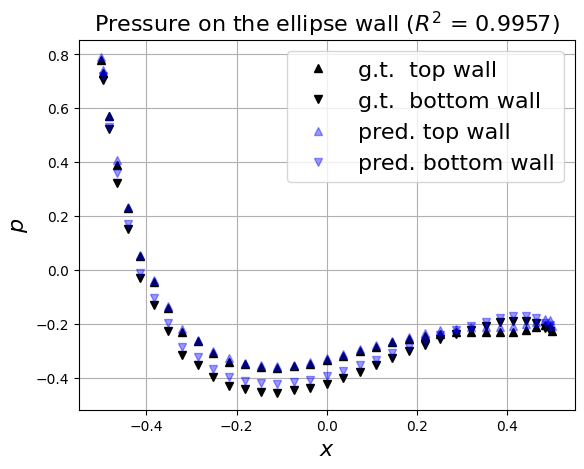

Flow-Matching Graph Net R2 = 0.9890 at t=3


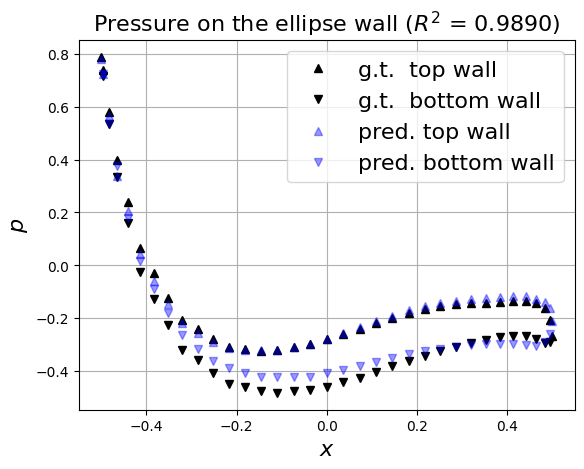

Latent Flow-Matching Graph Net R2 = 0.9970 at t=44


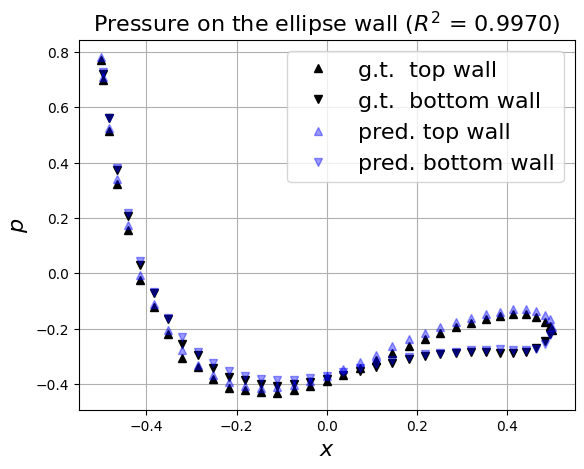

In [7]:
graph = dataset.get_sequence(SIM_IDX, n_in=T[SIM_IDX])

# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = DGN.sample(graph, steps=steps)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"DGN R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = LDGN.sample(graph, steps=steps)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"LDGN R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# Vanilla Graph Net inference
with torch.no_grad():
    VanillaGN.eval()
    pred = VanillaGN(graph)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)] 
r2, t = np.max(r2), np.argmax(r2)
print(f"Vanilla Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# Bayesian Graph Net inference
pred = BayesianGN.sample(graph)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Bayesian Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# Gaussian Mixture Graph Net inference
pred = GaussianMixGN.sample(graph)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Gaussian Mixture Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# VGAE inference
pred = VGAE.sample(graph)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"VGAE R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# Flow-Matching Graph Net inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = FMGN.sample(graph, steps=steps)
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Flow-Matching Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

# Latent Flow-Matching Graph Net inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = LFMGN.sample(graph, steps=steps) 
# Compute the accuracy
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in graph.target.split(1, dim=1)]
r2, t = np.max(r2), np.argmax(r2)
print(f"Latent Flow-Matching Graph Net R2 = {r2:.4f} at t={t}")
# Plot the results
plot(graph.pos, graph.target[:,t], pred, r2)

## Distribution inference
We approximate the learned distributions by sampling many times. To quantify the distributional accuracy we compute the Wasserstein-2 distance considering the predicted distribution as a:
- 1D distribution at each node
- $|V|$-D distribution acrros the whole graph

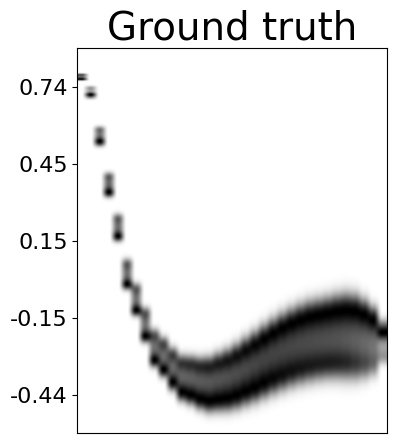

DGN
R2 of mean: 0.9983 R2 of std: 0.9783
Wasserstein-2 distance 1d: 0.0134
Wasserstein-2 distance nd: 0.1721


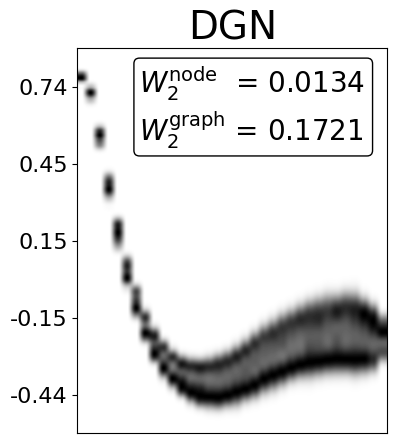

LDGN
R2 of mean: 0.9979 R2 of std: 0.9425
Wasserstein-2 distance 1d: 0.0161
Wasserstein-2 distance nd: 0.1664


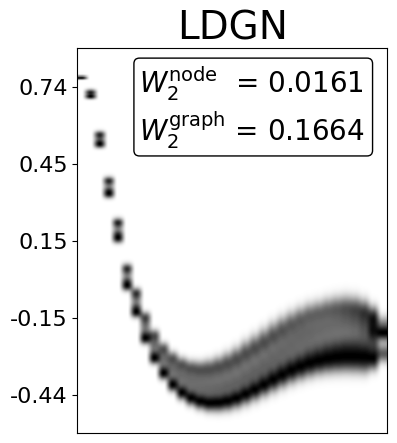

100%|██████████| 200/200 [00:03<00:00, 53.06it/s]


Bayesian Graph Net
R2 of mean: 0.9967 R2 of std: -0.7215
Wasserstein-2 distance 1d: 0.0371
Wasserstein-2 distance nd: 0.5976


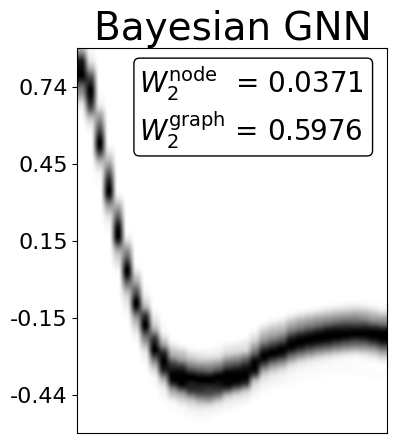

Gaussian Mixture Graph Net
R2 of mean: 0.9716 R2 of std: 0.1204
Wasserstein-2 distance 1d: 0.0527
Wasserstein-2 distance nd: 0.7160


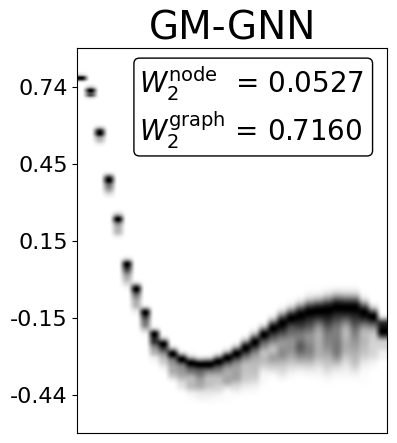

VGAE
R2 of mean: 0.9997 R2 of std: 0.9265
Wasserstein-2 distance 1d: 0.0112
Wasserstein-2 distance nd: 0.1980


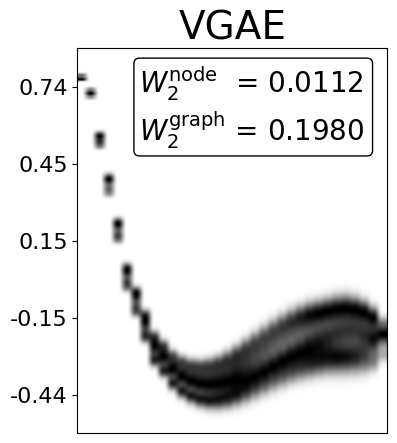

Flow-Matching Graph Net
R2 of mean: 0.9979 R2 of std: 0.9382
Wasserstein-2 distance 1d: 0.0159
Wasserstein-2 distance nd: 0.1855


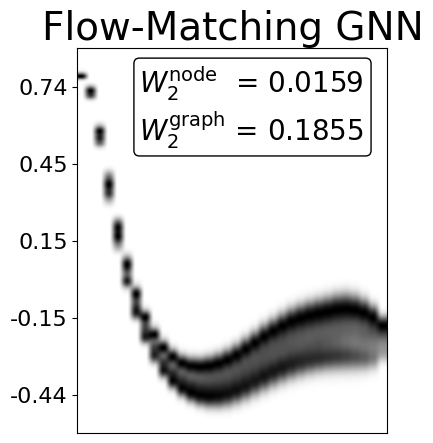

Latent Flow-Matching Graph Net
R2 of mean: 0.9988 R2 of std: 0.9848
Wasserstein-2 distance 1d: 0.0117
Wasserstein-2 distance nd: 0.1498


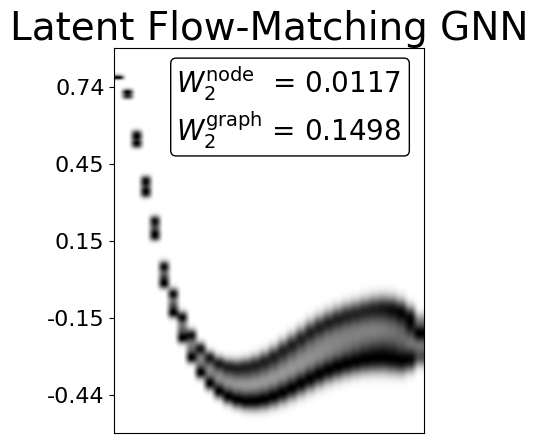

In [8]:
NUM_SAMPLES = 200
BATCH_SIZE  = 200 # Number of samples generated in parallel. Reduce this number if you run out of memory.

graph = dataset.get_sequence(SIM_IDX, n_in=T[SIM_IDX])
gt_mean = graph.target.mean(dim=1)
gt_std  = graph.target.std (dim=1)
# Plot the ground-truth PDF on the upper half of the ellipse
vmin, vmax = graph.target.min().item() - 0.1, graph.target.max().item() + 0.1
pdf(graph.pos, graph.target, 'Ground truth', vmin=vmin, vmax=vmax)

# DGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = DGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('DGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'DGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# LDGN inference
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)
pred = LDGN.sample_n(NUM_SAMPLES, graph,  steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('LDGN')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'LDGN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# Bayesian Graph Net inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        BayesianGN.sample(graph).cpu()
    )
pred = torch.concatenate(pred_list, dim=1) 
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Bayesian Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'Bayesian GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# Gaussian Mixture Graph Net inference
pred = GaussianMixGN.sample_n(NUM_SAMPLES, graph, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Gaussian Mixture Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'GM-GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# VGAE inference
pred = VGAE.sample_n(NUM_SAMPLES, graph, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('VGAE')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'VGAE', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# FMGN inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = FMGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Flow-Matching Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'Flow-Matching GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)

# LFMGN inference
steps = np.linspace(0, 1, NUM_DENOISING_STEPS + 1)
pred = LFMGN.sample_n(NUM_SAMPLES, graph, steps=steps, batch_size=BATCH_SIZE).cpu().squeeze(-1)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('Latent Flow-Matching Graph Net')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the PDF on the upper half of the ellipse
pdf(graph.pos, pred, 'Latent Flow-Matching GNN', w2_distance_1d=w2_distance_1d, w2_distance_nd=w2_distance_nd, vmin=vmin, vmax=vmax)